<a href="https://colab.research.google.com/github/VoMinhKhoii/hcmut-project-cuoi-khoa/blob/ntnam/DICET_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading and inspecting the dataset

In [12]:
import pandas as pd

# 1. Load & Inspect ---------------------------------------------------------

df = pd.read_csv('twitter_training.csv')

print("ROWS × COLS:", df.shape)
df.columns = ['id', 'game', 'sentiment', 'text'] # rename the columns
print("\nCOLUMN NAMES:", list(df.columns))

# Preview types & missing
print(df.info())
print("Missing values before dropping rows with null text:")
print(df.isnull().sum())

ROWS × COLS: (74681, 4)

COLUMN NAMES: ['id', 'game', 'sentiment', 'text']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74681 non-null  int64 
 1   game       74681 non-null  object
 2   sentiment  74681 non-null  object
 3   text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
Missing values before dropping rows with null text:
id             0
game           0
sentiment      0
text         686
dtype: int64


## Cleaning data by dropping nulls and normalizing texts

In [13]:
import re

# 2. Basic Cleaning ---------------------------------------------------------

# Drop duplicates & missing tweets
df.drop_duplicates(subset='text', inplace=True)
df.dropna(subset=['text'], inplace=True)

# Normalize text
def clean_text(t):
    t = t.lower()
    t = re.sub(r'http\S+','', t)             # URLs
    t = re.sub(r'@\w+','', t)                # mentions
    t = re.sub(r'#\w+','', t)                # hashtags
    t = re.sub(r'[^a-z0-9\s]', '', t)        # punctuation
    return t.strip()

df['clean_text'] = df['text'].apply(clean_text)
# Display the first few rows of the DataFrame with the normalized text
display(df[['text', 'clean_text']].head())

,text,clean_text
0,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
1,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all
2,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
3,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...
4,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...


## Visualizing to get the overview of the dataset

/tmp/ipython-input-288723186.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='pastel')


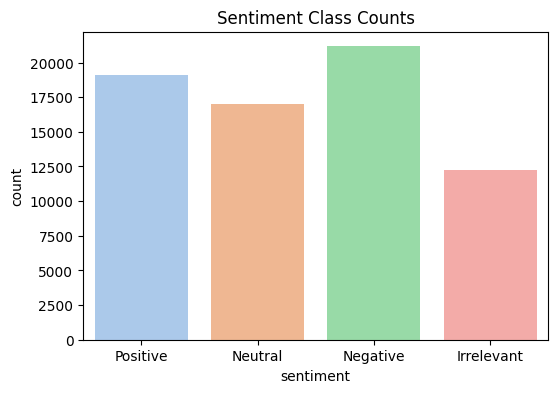

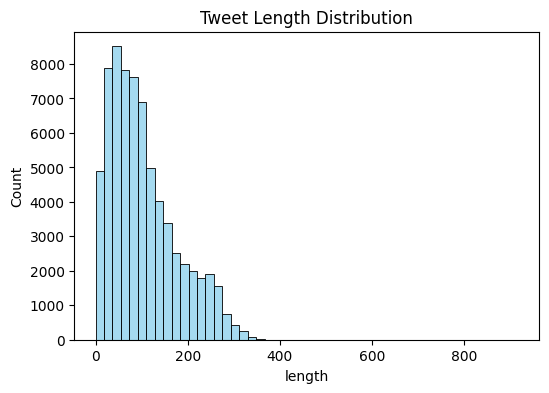

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Column‐Specific Checks ------------------------------------------------

# 3.1 Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette='pastel')
plt.title('Sentiment Class Counts')
plt.show()

# 3.2 Tweet length
df['length'] = df['clean_text'].str.len()
plt.figure(figsize=(6,4))
sns.histplot(df['length'], bins=50, color='skyblue')
plt.title('Tweet Length Distribution')
plt.show()

## Visulizaing with WordCloud by sentiment

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


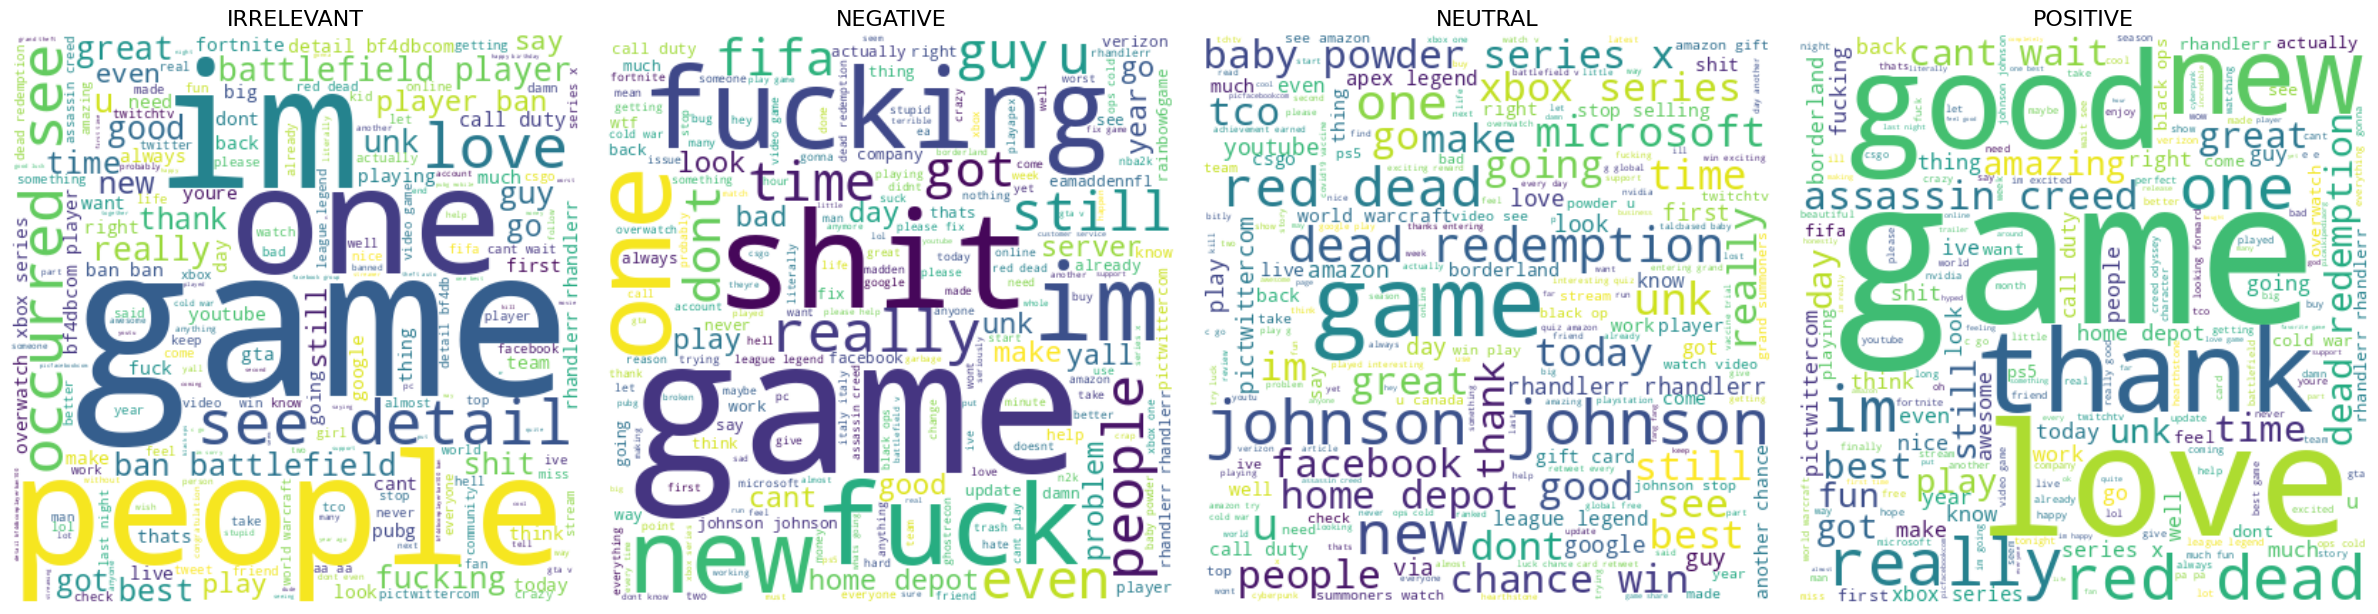

In [15]:
# Ensure necessary NLTK data is downloaded
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('stopwords')
except LookupError:
    nltk.download('stopwords')


from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # Import WordNetLemmatizer

# 4. Word Cloud by Sentiment -----------------------------------------------

# Prepare stopwords & tokenizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(t):
    tokens = t.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

df['tokens'] = df['clean_text'].apply(preprocess)

# Generate one big string per sentiment
groups = df.groupby('sentiment')['tokens'].apply(lambda x: ' '.join(x))

# Adjust subplot creation to accommodate all sentiment categories
fig, axs = plt.subplots(1, len(groups), figsize=(len(groups)*6, 6))

for ax, (sent, text) in zip(axs, groups.items()):
    wc = WordCloud(width=400, height=400, background_color='white')\
         .generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(sent.upper(), fontsize=16)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Visualizing Top Hashtags and Top Mentions

/tmp/ipython-input-2557204551.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_mentions.index, x=top_mentions.values, palette='rocket')


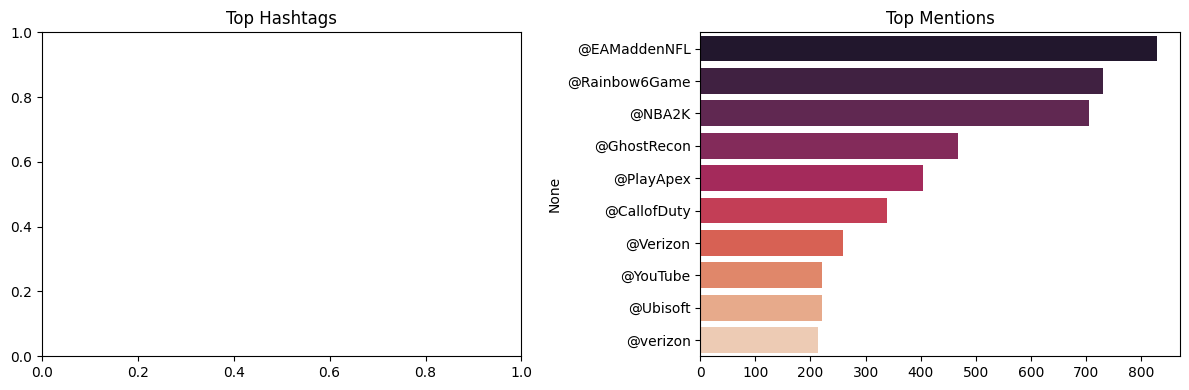

In [16]:
# 5. Top Hashtags & Mentions ------------------------------------------------

# Extract hashtags and mentions
df['hashtags'] = df['text'].str.findall(r'#\w+')
df['mentions'] = df['text'].str.findall(r'@\w+')

# Flatten and count top 10
top_hashtags = pd.Series(sum(df['hashtags'], [])).value_counts().nlargest(10)
top_mentions = pd.Series(sum(df['mentions'], [])).value_counts().nlargest(10)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(y=top_hashtags.index, x=top_hashtags.values, palette='mako')
plt.title('Top Hashtags')
plt.subplot(1,2,2)
sns.barplot(y=top_mentions.index, x=top_mentions.values, palette='rocket')
plt.title('Top Mentions')
plt.tight_layout()
plt.show()

## Visualizing N-gram frequency (Unigrams & Bigrams)

/tmp/ipython-input-1537706887.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ngrams.values, y=top_ngrams.index, palette='coolwarm')


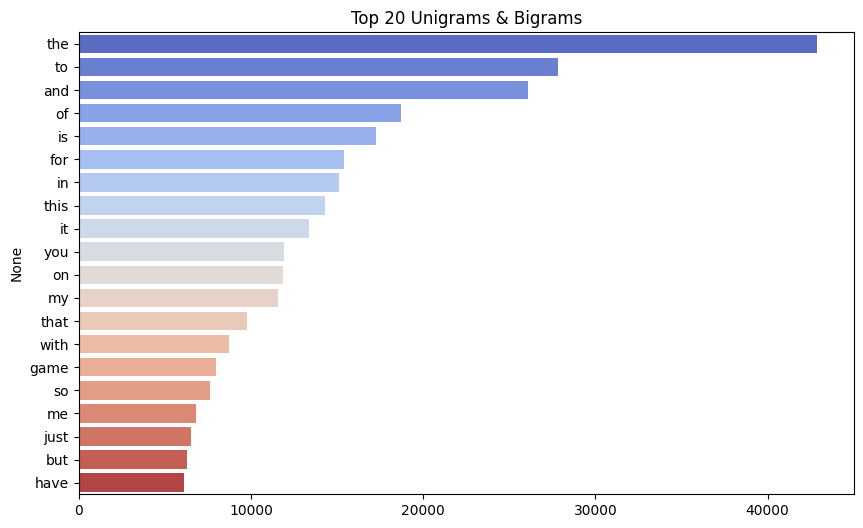

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# 6. N-gram Frequency -------------------------------------------------------

vectorizer = CountVectorizer(ngram_range=(1,2), max_features=30)
X = vectorizer.fit_transform(df['clean_text'])
freq = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))
top_ngrams = pd.Series(freq).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_ngrams.values, y=top_ngrams.index, palette='coolwarm')
plt.title('Top 20 Unigrams & Bigrams')
plt.show()

## Visualizing N-gram frequency again after removing stopwords to make it more meaningful

In [20]:
# Create a function to remove stopwords
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply the function to create the new column
df['clean_text_no_stopwords'] = df['clean_text'].apply(remove_stopwords)

# Display the first few rows to verify
display(df[['clean_text', 'clean_text_no_stopwords']].head())

,clean_text,clean_text_no_stopwords
0,i am coming to the borders and i will kill you...,coming borders kill
1,im getting on borderlands and i will kill you all,im getting borderlands kill
2,im coming on borderlands and i will murder you...,im coming borderlands murder
3,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder
4,im getting into borderlands and i can murder y...,im getting borderlands murder


/tmp/ipython-input-3103495206.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ngrams_no_stopwords.values, y=top_ngrams_no_stopwords.index, palette='coolwarm')


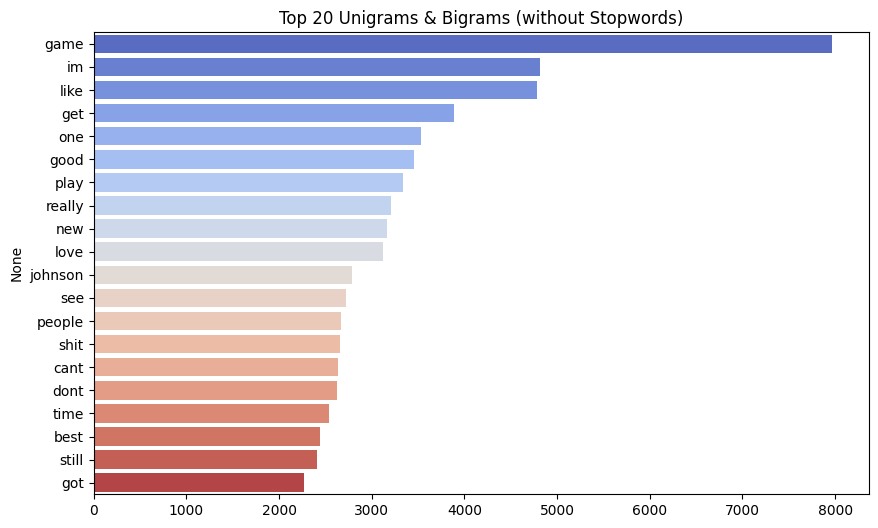

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_no_stopwords = CountVectorizer(ngram_range=(1,2), max_features=30)
X_no_stopwords = vectorizer_no_stopwords.fit_transform(df['clean_text_no_stopwords'])
freq_no_stopwords = dict(zip(vectorizer_no_stopwords.get_feature_names_out(), X_no_stopwords.sum(axis=0).A1))
top_ngrams_no_stopwords = pd.Series(freq_no_stopwords).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_ngrams_no_stopwords.values, y=top_ngrams_no_stopwords.index, palette='coolwarm')
plt.title('Top 20 Unigrams & Bigrams (without Stopwords)')
plt.show()

## Save the cleaned data

In [19]:
# 7. Save Cleaned Data ------------------------------------------------------

df.to_csv('twitter_training_cleaned.csv', index=False)